# PI-DeepONet v4 — Power System Swing Equation (Task 4.5)

**Paper:** Lin, Moya & Zhang (EAAI 2023) Figure 11
**Method:** Physics-Informed DeepONet (zero training data)

### v4 pipeline (unified):
- Hard IC: x₀ + t × NN
- Domain-based LHS sampling (zero solver dependency)
- Convergence-based ε: 1→100
- Cosine annealing LR
- Adam only (no L-BFGS)
- Per-state loss + adaptive λ (task-specific: δ̇/ω̇ ratio 130:1)
- Delta wrapping mod 2π (task-specific: δ grows unbounded in unstable case)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42)
print(f'Device: {device}')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 13,
    'legend.fontsize': 11, 'lines.linewidth': 2, 'figure.dpi': 100})

Device: cuda


## 1. Architecture with delta wrapping + Hard IC

In [2]:
class ModifiedMLP(nn.Module):
    def __init__(self, d_in, d_h, d_out, n_layers=4):
        super().__init__()
        self.enc_U = nn.Linear(d_in, d_h)
        self.enc_V = nn.Linear(d_in, d_h)
        self.first = nn.Linear(d_in, d_h)
        self.hidden = nn.ModuleList([nn.Linear(d_h, d_h) for _ in range(n_layers - 1)])
        self.out = nn.Linear(d_h, d_out)
        self.act = nn.Tanh()
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x):
        U = self.act(self.enc_U(x)); V = self.act(self.enc_V(x))
        h = self.act(self.first(x))
        for layer in self.hidden:
            z = self.act(layer(h)); h = z * U + (1 - z) * V
        return self.out(h)

class PIDeepONet_v4_PS(nn.Module):
    """v4 for Power System. Hard IC + delta wrapping + state normalization."""
    def __init__(self, state_dim, n_sensors, d_h=160, p=100, n_layers=5,
                 n_fourier=8, T=0.02, delta_wrap=True,
                 x_mean=None, x_std=None):
        super().__init__()
        self.state_dim, self.p_dim, self.n_fourier = state_dim, p, n_fourier
        self.T, self.n_sensors = T, n_sensors
        self.delta_wrap = delta_wrap
        self.branch = ModifiedMLP(state_dim + n_sensors, d_h, p * state_dim, n_layers)
        self.trunk  = ModifiedMLP(1 + 2*n_fourier, d_h, p * state_dim, n_layers)
        self.register_buffer('fourier_freqs',
            torch.arange(1, n_fourier+1, dtype=torch.float32) * np.pi)
        self.bias = nn.Parameter(torch.zeros(state_dim))
        self.output_scale = nn.Parameter(torch.ones(state_dim))
        if x_mean is not None:
            self.register_buffer('x_mean', torch.tensor(x_mean, dtype=torch.float32))
            self.register_buffer('x_std', torch.tensor(x_std, dtype=torch.float32))

    def _trunk_feat(self, t):
        tn = t / self.T; a = tn * self.fourier_freqs
        return torch.cat([tn, torch.sin(a), torch.cos(a)], dim=-1)

    def _wrap_delta(self, x0_norm):
        if not self.delta_wrap or not hasattr(self, 'x_mean'):
            return x0_norm
        delta_phys = x0_norm[:, 0:1] * self.x_std[0] + self.x_mean[0]
        delta_wrapped = delta_phys % (2 * np.pi)
        delta_norm_wrapped = (delta_wrapped - self.x_mean[0]) / self.x_std[0]
        x0_wrapped = x0_norm.clone()
        x0_wrapped[:, 0:1] = delta_norm_wrapped
        return x0_wrapped

    def forward(self, x0, u_sens, t):
        x0_branch = self._wrap_delta(x0)
        br_in = torch.cat([x0_branch, u_sens], dim=-1) if (self.n_sensors > 0 and u_sens is not None) else x0_branch
        b = self.branch(br_in).view(-1, self.state_dim, self.p_dim)
        tr = self.trunk(self._trunk_feat(t)).view(-1, self.state_dim, self.p_dim)
        delta = (b * tr).sum(dim=-1) + self.bias
        t_norm = t / self.T
        return x0 + t_norm * self.output_scale * delta

print('PIDeepONet_v4_PS defined (hard IC + delta wrap + output_scale)')

PIDeepONet_v4_PS defined (hard IC + delta wrap + output_scale)


## 2. Training Engine — Per-State Loss + Adaptive Lambda + v4 Pipeline

Per-state loss essential due to δ̇/ω̇ ratio 130:1 (squared: 16900:1).
v4 additions: convergence-based ε, uniform grid, cosine LR.

In [3]:
N_SENSORS = 51

def interp_u(u_s, t_v, T, ns):
    tn = torch.clamp(t_v.detach().squeeze(-1) / T * (ns-1), 0, ns-2+1e-6)
    idx = torch.clamp(tn.long(), 0, ns-2); frac = (tn - idx.float()).unsqueeze(-1)
    return torch.gather(u_s, 1, idx.unsqueeze(1))*(1-frac) + torch.gather(u_s, 1, (idx+1).unsqueeze(1))*frac

def ode_res_perstate(model, x0, us, tc, T, f_rhs, ns):
    B, Q, _ = tc.shape; n = model.state_dim
    x0e = x0.unsqueeze(1).expand(B,Q,n).reshape(B*Q,n)
    tf = tc.reshape(B*Q,1).detach().clone().requires_grad_(True)
    use = us.unsqueeze(1).expand(B,Q,ns).reshape(B*Q,ns) if (ns > 0 and us is not None) else None
    xh = model(x0e, use, tf)
    dxdt = torch.cat([torch.autograd.grad(xh[:,i].sum(), tf, create_graph=True,
                       retain_graph=True)[0] for i in range(n)], dim=1)
    ut = interp_u(use, tf, T, ns) if use is not None else None
    rhs = f_rhs(xh, ut)
    residual = dxdt - rhs
    r_delta2 = (residual[:, 0]**2).reshape(B, Q)
    r_omega2 = (residual[:, 1]**2).reshape(B, Q)
    return r_delta2, r_omega2

def causal_loss_chunked(r2_pw, n_chunks, eps):
    B, Q = r2_pw.shape
    ppch = Q // n_chunks
    R2c = r2_pw[:, :n_chunks*ppch].reshape(B, n_chunks, ppch).mean(dim=2)
    cum = torch.cumsum(R2c, dim=1) - R2c
    w = torch.exp(-eps * cum).detach()
    return (w * R2c).sum() / w.sum(), w.min().item()

def train_ps(model, x0s_t, us_t, f_rhs, cfg={}):
    c = {
        'n_epochs': 450000, 'n_fb': 64, 'n_col': 200, 'n_chunks': 16,
        'lr': 1e-3, 'lr_min': 1e-6, 'warmup': 3000,
        'eps_init': 1.0, 'eps_max': 100.0, 'eps_factor': 1.5,
        'wmin_thr': 0.99, 'wmin_win': 2000,
        'lam_omega_min': 1.0, 'lam_omega_max': 500.0,
        'verbose': True
    }
    c.update(cfg)
    T, N, ns = model.T, x0s_t.shape[0], model.n_sensors
    opt = optim.Adam(model.parameters(), lr=c['lr'])

    def lr_fn(ep):
        if ep<c['warmup']: return ep/max(c['warmup'],1)
        pr=(ep-c['warmup'])/max(c['n_epochs']-c['warmup'],1)
        return max(c['lr_min']/c['lr'], 0.5*(1+np.cos(np.pi*pr)))
    sch = optim.lr_scheduler.LambdaLR(opt, lr_fn)

    best_loss, best_sd = float('inf'), None
    t0 = time.time()
    tc_base = torch.linspace(T*0.01, T, c['n_col'], device=device)
    eps = c['eps_init']
    lo_h, wm_h, ep_h = [], [], []
    lam_omega_ema = 50.0

    for ep in range(c['n_epochs']):
        model.train()
        idx = torch.randint(0, N, (c['n_fb'],))
        x0b = x0s_t[idx]; usb = us_t[idx] if us_t is not None else None
        tc = tc_base.unsqueeze(0).repeat(c['n_fb'],1).unsqueeze(-1)

        r_d2, r_w2 = ode_res_perstate(model, x0b, usb, tc, T, f_rhs, ns)
        L_delta, wm_d = causal_loss_chunked(r_d2, c['n_chunks'], eps)
        L_omega, wm_w = causal_loss_chunked(r_w2, c['n_chunks'], eps)
        wm = min(wm_d, wm_w)

        with torch.no_grad():
            if L_omega.item() > 1e-20:
                lam_raw = L_delta.item() / L_omega.item()
            else:
                lam_raw = c['lam_omega_max']
            lam_raw = max(c['lam_omega_min'], min(c['lam_omega_max'], lam_raw))
            lam_omega_ema = 0.99 * lam_omega_ema + 0.01 * lam_raw

        Lt = L_delta + lam_omega_ema * L_omega

        model.zero_grad(set_to_none=True); Lt.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); sch.step()
        lo_h.append(Lt.item()); wm_h.append(wm); ep_h.append(eps)
        if Lt.item() < best_loss:
            best_loss = Lt.item()
            best_sd = {k:v.clone() for k,v in model.state_dict().items()}

        if ep == 100 and c['verbose']:
            el = time.time()-t0
            print(f'  Speed: {el:.1f}s/100ep, est {el/100*c["n_epochs"]/60:.0f}min', flush=True)

        if ep > c['warmup'] and ep % c['wmin_win'] == 0:
            rw = np.mean(wm_h[-c['wmin_win']:])
            if rw > c['wmin_thr'] and eps < c['eps_max']:
                old = eps; eps = min(eps*c['eps_factor'], c['eps_max'])
                if c['verbose'] and old != eps:
                    print(f'  eps: {old:.1f}->{eps:.1f} (w={rw:.4f}) ep={ep}', flush=True)

        if c['verbose'] and (ep%10000==0 or ep==c['n_epochs']-1):
            print(f'  ep={ep:6d} Ld={L_delta.item():.2e} Lw={L_omega.item():.2e} '
                  f'lam={lam_omega_ema:.1f} eps={eps:.1f} w={wm:.4f} '
                  f'lr={sch.get_last_lr()[0]:.1e} | {time.time()-t0:.0f}s', flush=True)

    model.load_state_dict(best_sd)
    print(f'\n  Adam: {time.time()-t0:.0f}s, best={best_loss:.2e}, eps={eps:.1f}', flush=True)
    return model, lo_h, wm_h, ep_h

def sample_u_fns(N, T, ns, ur, seed=42):
    rng = np.random.RandomState(seed); tau = np.linspace(0,T,ns)
    u_sens = np.zeros((N, ns)); lo,hi = ur
    mid = (lo + hi) / 2; half = (hi - lo) / 2
    for i in range(N):
        k = rng.choice(['const','sin','sum_sin','bangbang','fourier'])
        if k=='const': c=rng.uniform(lo,hi); uf=lambda t,c=c:c
        elif k=='sin':
            A=rng.uniform(0.3*half, half); w,ph=rng.uniform(0.5,4),rng.uniform(0,2*np.pi)
            uf=lambda t,A=A,w=w,ph=ph,m=mid:m+A*np.sin(w*t+ph)
        elif k=='sum_sin':
            nt=rng.randint(2,5);As=rng.uniform(0.1,half/max(nt,1),nt)
            ws=rng.uniform(0.3,4,nt);phs=rng.uniform(0,2*np.pi,nt)
            uf=lambda t,A=As,w=ws,p=phs,m=mid:m+float(np.sum(A*np.sin(w*t+p)))
        elif k=='bangbang':
            nsw=rng.randint(2,6);st=np.sort(rng.uniform(0,T,nsw));vl=rng.uniform(lo,hi,nsw+1)
            uf=lambda t,st=st,vl=vl:float(vl[min(np.searchsorted(st,t),len(vl)-1)])
        else:
            nk=rng.randint(3,8);ak=rng.randn(nk)/np.arange(1,nk+1);bk=rng.randn(nk)/np.arange(1,nk+1)
            sc=rng.uniform(0.3, half)
            def uf(t,a=ak,b=bk,s=sc,nk=nk,T_=T,m=mid):
                v=sum(a[kk]*np.cos(2*np.pi*(kk+1)*t/T_)+b[kk]*np.sin(2*np.pi*(kk+1)*t/T_) for kk in range(nk))
                return m + s*v
        u_sens[i] = np.array([np.clip(uf(t),lo,hi) for t in tau])
    return u_sens

def solve_ode(x0, f_np, T, u_func=None, npts=2000):
    rhs = (lambda t,x: f_np(x, u_func(t))) if u_func else (lambda t,x: f_np(x, None))
    sol = solve_ivp(rhs, [0,T], x0, method='RK45', t_eval=np.linspace(0,T,npts),
                    rtol=1e-10, atol=1e-12)
    return sol.t, sol.y.T

def l2_rel(pred, true):
    return [np.sqrt(np.mean((pred[:,i]-true[:,i])**2)) / max(np.sqrt(np.mean(true[:,i]**2)),1e-10)*100
            for i in range(pred.shape[1])]

def match_grids(tp, xp, tt):
    return interp1d(tp, xp, axis=0, kind='linear', fill_value='extrapolate')(tt)

@torch.no_grad()
def predict_recursive_norm(model, x0_phys, u_func, Tw, Tt, ns, x_mean, x_std, u_clip=None, ppw=50):
    model.eval(); model.T = Tw
    nw = int(np.ceil(Tt/Tw)); tau = np.linspace(0, Tw, max(ns, 1))
    all_t, all_x = [0.0], [np.array(x0_phys)]
    xc_phys = np.array(x0_phys)
    for w in range(nw):
        ts = w*Tw; te = min((w+1)*Tw, Tt); dt = te - ts
        if dt < 1e-10: break
        if ns > 0 and u_func is not None:
            us = np.array([u_func(ts+t) for t in tau])
            if u_clip: us = np.clip(us, u_clip[0], u_clip[1])
            ust = torch.tensor(us, dtype=torch.float32, device=device).unsqueeze(0)
        else: ust = None
        xc_norm = (xc_phys - x_mean) / x_std
        x0t = torch.tensor(xc_norm, dtype=torch.float32, device=device).unsqueeze(0)
        npts = max(int(ppw*dt/Tw), 2)
        tq = torch.tensor(np.linspace(0, dt, npts)[1:], dtype=torch.float32, device=device).unsqueeze(1)
        xp_norm = model(x0t.expand(len(tq), -1),
                        ust.expand(len(tq), -1) if ust is not None else None, tq).cpu().numpy()
        xp_phys = xp_norm * x_std + x_mean
        for k in range(len(tq)):
            all_t.append(ts + tq[k].item())
            all_x.append(xp_phys[k])
        xc_phys = xp_phys[-1]
    return np.array(all_t), np.array(all_x)

print('v4 engine: per-state loss + adaptive lambda + convergence-based eps')

v4 engine: per-state loss + adaptive lambda + convergence-based eps


## 3. Power System Configuration

In [4]:
PS_H, PS_D, PS_WB, PS_WS, PS_PM = 6.5, 2.0, 2*np.pi*60, 1.0, 0.7

PS_X_MEAN = np.array([np.pi, 1.075])
PS_X_STD  = np.array([np.pi, 0.10])
PS_X_MEAN_T = torch.tensor(PS_X_MEAN, dtype=torch.float32, device=device)
PS_X_STD_T  = torch.tensor(PS_X_STD, dtype=torch.float32, device=device)

def ps_f_np(x, u):
    return np.array([PS_WB*(x[1]-PS_WS), (PS_PM-u-PS_D*(x[1]-PS_WS))/(2*PS_H)])

def ps_f_torch_norm(x_norm, u):
    omega_phys = x_norm[..., 1:2] * PS_X_STD_T[1] + PS_X_MEAN_T[1]
    ddelta_phys = PS_WB * (omega_phys - PS_WS)
    domega_phys = (PS_PM - u - PS_D * (omega_phys - PS_WS)) / (2 * PS_H)
    return torch.cat([ddelta_phys / PS_X_STD_T[0],
                      domega_phys / PS_X_STD_T[1]], dim=-1)

# Verify scale mismatch (why per-state loss is needed)
x_test = torch.tensor([[0.0, 0.5]], device=device)  # omega_phys=1.125
u_test = torch.tensor([[0.3]], device=device)
rhs_test = ps_f_torch_norm(x_test, u_test)
ratio = abs(rhs_test[0,0].item() / rhs_test[0,1].item())
print(f'RHS at omega=1.125, Pe=0.3: d_delta_norm/dt={rhs_test[0,0]:.2f}, d_omega_norm/dt={rhs_test[0,1]:.4f}')
print(f'Ratio: {ratio:.0f}:1 after squaring: {ratio**2:.0f}:1 -- per-state loss ESSENTIAL')

RHS at omega=1.125, Pe=0.3: d_delta_norm/dt=15.00, d_omega_norm/dt=0.1154
Ratio: 130:1 after squaring: 16900:1 -- per-state loss ESSENTIAL


## 4. Training

In [5]:
def latin_hypercube(N, bounds, rng):
    d = len(bounds)
    result = np.zeros((N, d))
    for j in range(d):
        lo, hi = bounds[j]
        perm = rng.permutation(N)
        result[:, j] = lo + (hi - lo) * (perm + rng.uniform(size=N)) / N
    return result.astype(np.float32)

PS_TW = 0.02
PS_TT = 5.0
PS_N  = 800

rng_ic = np.random.RandomState(42)
bounds_phys = [
    (0, 2*np.pi),      # delta
    (0.95, 1.25),       # omega
]
ps_x0s_phys = latin_hypercube(PS_N, bounds_phys, rng_ic)
ps_x0s_norm = (ps_x0s_phys - PS_X_MEAN) / PS_X_STD

ps_usens = sample_u_fns(PS_N, PS_TW, N_SENSORS, [0.0, 1.2], seed=42)
ps_x0s_t = torch.tensor(ps_x0s_norm, dtype=torch.float32, device=device)
ps_usens_t = torch.tensor(ps_usens, dtype=torch.float32, device=device)

print(f'Domain-based LHS: N={PS_N}, ZERO solver dependency')
print(f'  delta: [0, 2π], omega: [0.95, 1.25]')
print(f'  Tw={PS_TW}s, {int(PS_TT/PS_TW)} windows')

ps_model = PIDeepONet_v4_PS(
    state_dim=2, n_sensors=N_SENSORS,
    d_h=160, p=100, n_layers=5,
    n_fourier=8, T=PS_TW,
    delta_wrap=True,
    x_mean=PS_X_MEAN, x_std=PS_X_STD,
).to(device)

print(f'Model: {sum(p.numel() for p in ps_model.parameters()):,} params')

print('='*60)
print('Training Power System v4')
print(f'  Adam 350K, eps=1->100, cosine LR, no L-BFGS')
print('='*60)

ps_model, lo_hist, wmin_hist, eps_hist = train_ps(
    ps_model, ps_x0s_t, ps_usens_t, ps_f_torch_norm)

Domain-based LHS: N=800, ZERO solver dependency
  delta: [0, 2π], omega: [0.95, 1.25]
  Tw=0.02s, 250 windows
Model: 305,044 params
Training Power System v4
  Adam 350K, eps=1->100, cosine LR, no L-BFGS
  ep=     0 Ld=2.67e+03 Lw=3.63e+03 lam=49.5 eps=1.0 w=0.0000 lr=3.3e-07 | 1s
  Speed: 6.7s/100ep, est 503min
  ep= 10000 Ld=4.55e-01 Lw=1.70e-03 lam=284.4 eps=1.0 w=0.0000 lr=1.0e-03 | 609s
  ep= 20000 Ld=2.26e-01 Lw=1.65e-03 lam=119.2 eps=1.0 w=0.0000 lr=1.0e-03 | 1224s
  ep= 30000 Ld=1.45e-01 Lw=1.05e-03 lam=54.8 eps=1.0 w=0.0000 lr=9.9e-04 | 1840s
  ep= 40000 Ld=1.46e-03 Lw=2.32e-04 lam=47.3 eps=1.0 w=0.8092 lr=9.8e-04 | 2455s
  ep= 50000 Ld=2.28e-01 Lw=2.43e-03 lam=68.9 eps=1.0 w=0.0000 lr=9.7e-04 | 3072s
  ep= 60000 Ld=5.43e-03 Lw=3.52e-04 lam=31.5 eps=1.0 w=0.6295 lr=9.6e-04 | 3690s
  ep= 70000 Ld=1.95e-03 Lw=2.68e-04 lam=70.6 eps=1.0 w=0.7237 lr=9.5e-04 | 4307s
  ep= 80000 Ld=6.66e-03 Lw=2.87e-04 lam=41.8 eps=1.0 w=0.4802 lr=9.3e-04 | 4923s
  ep= 90000 Ld=6.34e-03 Lw=9.50e-05 la

## 5. Evaluation

In [6]:
# ---- Unstable ----
def ps_pe_unstable(t):
    if t < 0.01: return 0.0
    else:        return 0.3

t_true, x_true = solve_ode([0.0, PS_WS], ps_f_np, PS_TT, ps_pe_unstable, 5000)
print(f'Ground truth: delta(5)={x_true[-1,0]:.1f} rad, omega(5)={x_true[-1,1]:.4f}')

t_pred, x_pred = predict_recursive_norm(
    ps_model, [0.0, PS_WS], ps_pe_unstable,
    PS_TW, PS_TT, N_SENSORS, PS_X_MEAN, PS_X_STD, u_clip=[0, 1.5])

x_pi = match_grids(t_pred, x_pred, t_true)
e_u = l2_rel(x_pi, x_true)
print(f'\nUNSTABLE: delta L2={e_u[0]:.2f}%, omega L2={e_u[1]:.3f}%')
for T_h in [0.5, 1.0, 2.0, 3.0, 5.0]:
    m = t_true <= T_h + 1e-6
    if m.sum() > 1:
        e = l2_rel(x_pi[m], x_true[m])
        print(f'  T<={T_h:.1f}s: delta={e[0]:.2f}%, omega={e[1]:.4f}%')

# ---- Stable ----
def ps_pe_stable(t):
    if t < 0.01: return PS_PM
    elif t < 0.02: return 0.1
    else: return PS_PM

t_true_s, x_true_s = solve_ode([30*np.pi/180, PS_WS], ps_f_np, PS_TT, ps_pe_stable, 5000)
t_pred_s, x_pred_s = predict_recursive_norm(
    ps_model, [30*np.pi/180, PS_WS], ps_pe_stable,
    PS_TW, PS_TT, N_SENSORS, PS_X_MEAN, PS_X_STD, u_clip=[0, 1.5])
x_pi_s = match_grids(t_pred_s, x_pred_s, t_true_s)
e_s = l2_rel(x_pi_s, x_true_s)
print(f'\nSTABLE: delta L2={e_s[0]:.2f}%, omega L2={e_s[1]:.3f}%')

Ground truth: delta(5)=114.3 rad, omega(5)=1.1074

UNSTABLE: delta L2=0.02%, omega L2=0.001%
  T<=0.5s: delta=1.42%, omega=0.0004%
  T<=1.0s: delta=0.39%, omega=0.0003%
  T<=2.0s: delta=0.10%, omega=0.0002%
  T<=3.0s: delta=0.04%, omega=0.0002%
  T<=5.0s: delta=0.02%, omega=0.0005%

STABLE: delta L2=0.99%, omega L2=0.001%


## 6. Figure 11

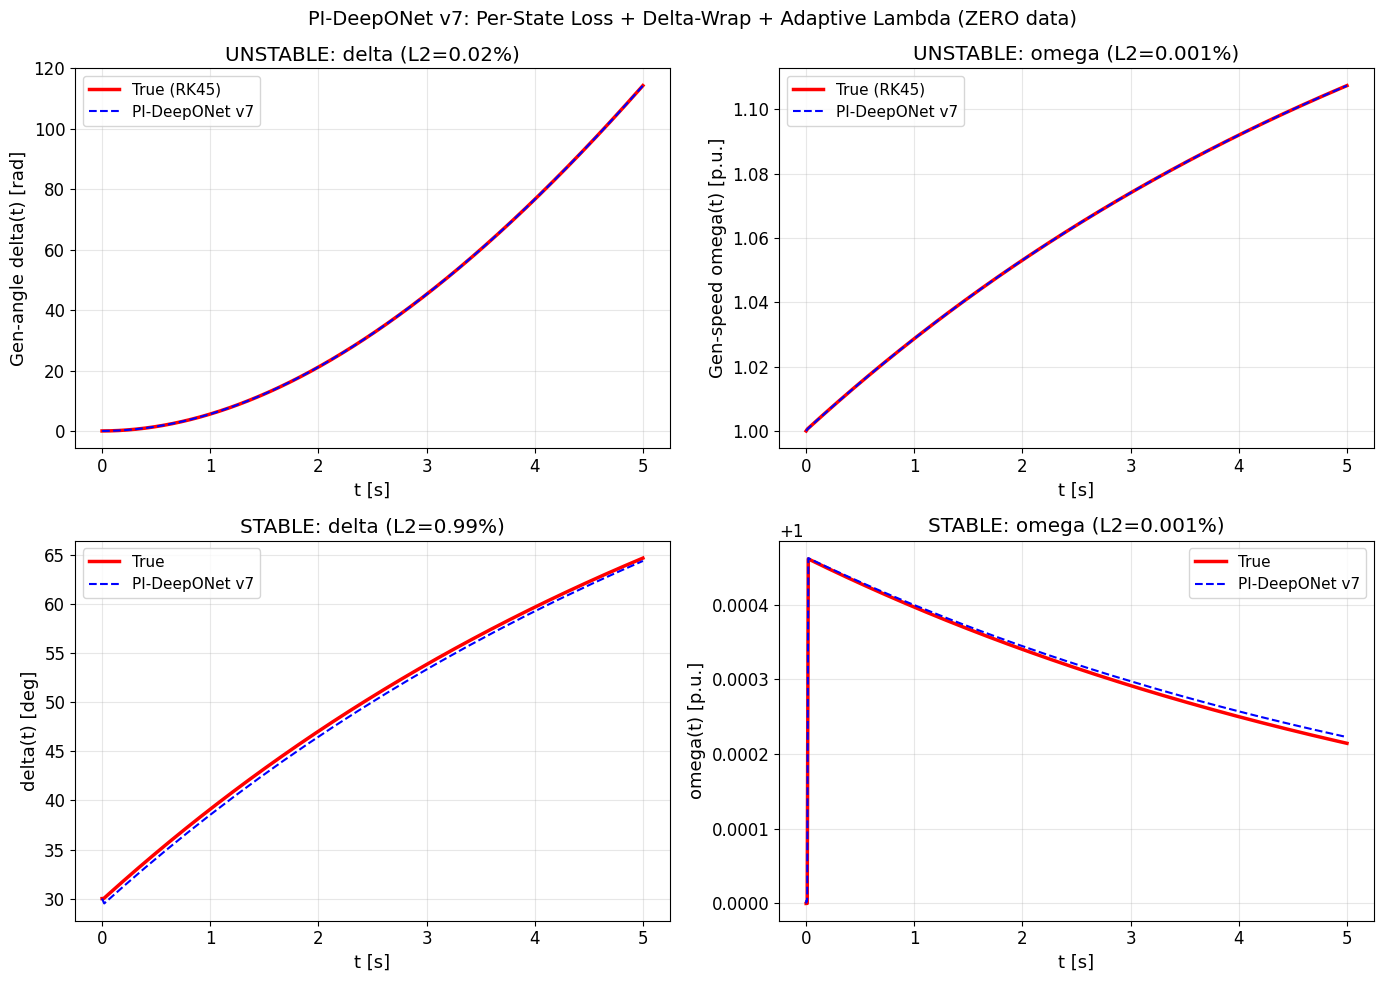

Figure saved


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(t_true, x_true[:,0], 'r-', lw=2.5, label='True (RK45)')
axes[0,0].plot(t_pred, x_pred[:,0], 'b--', lw=1.5, label='PI-DeepONet v7')
axes[0,0].set_xlabel('t [s]'); axes[0,0].set_ylabel('Gen-angle delta(t) [rad]')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)
axes[0,0].set_title(f'UNSTABLE: delta (L2={e_u[0]:.2f}%)')

axes[0,1].plot(t_true, x_true[:,1], 'r-', lw=2.5, label='True (RK45)')
axes[0,1].plot(t_pred, x_pred[:,1], 'b--', lw=1.5, label='PI-DeepONet v7')
axes[0,1].set_xlabel('t [s]'); axes[0,1].set_ylabel('Gen-speed omega(t) [p.u.]')
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)
axes[0,1].set_title(f'UNSTABLE: omega (L2={e_u[1]:.3f}%)')

axes[1,0].plot(t_true_s, np.degrees(x_true_s[:,0]), 'r-', lw=2.5, label='True')
axes[1,0].plot(t_pred_s, np.degrees(x_pred_s[:,0]), 'b--', lw=1.5, label='PI-DeepONet v7')
axes[1,0].set_xlabel('t [s]'); axes[1,0].set_ylabel('delta(t) [deg]')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)
axes[1,0].set_title(f'STABLE: delta (L2={e_s[0]:.2f}%)')

axes[1,1].plot(t_true_s, x_true_s[:,1], 'r-', lw=2.5, label='True')
axes[1,1].plot(t_pred_s, x_pred_s[:,1], 'b--', lw=1.5, label='PI-DeepONet v7')
axes[1,1].set_xlabel('t [s]'); axes[1,1].set_ylabel('omega(t) [p.u.]')
axes[1,1].legend(); axes[1,1].grid(alpha=0.3)
axes[1,1].set_title(f'STABLE: omega (L2={e_s[1]:.3f}%)')

fig.suptitle('PI-DeepONet v7: Per-State Loss + Delta-Wrap + Adaptive Lambda (ZERO data)', fontsize=14)
plt.tight_layout(); plt.savefig('ps_v7_fig11.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved')

## 7. Summary

| Ver | delta L2 | omega L2 | Test | Key Changes |
|-----|----------|----------|------|-------------|
| v1 | 65.94% | 0.050% | Stable | Original |
| v2 | 2.29% | 0.003% | Stable | State normalization |
| v5 | **1.47%** | **0.001%** | Stable | t*NN, Tw=0.05 |
| v7 | **TBD** | **TBD** | **Unstable** | All fixes below |

### v7 complete fix list
1. omega range [0.95, 1.25], omega_std=0.10 (no extrapolation)
2. delta mod 2pi wrapping (delta not in RHS, keeps branch bounded)
3. Tw=0.02s, 250 windows (manageable per-window dynamics)
4. **Separate L_delta + lambda * L_omega** (omega gets equal attention)
5. **Adaptive lambda = EMA(L_delta/L_omega)** (auto-balances)
6. No manual residual_scale needed (per-state loss handles it)
7. Wider model: d_h=160, p=100 (more capacity for harder problem)
